# Purpose

We need a clear count of geo-relevant subreddits so that we understand the current topic-model coverage and what we need to do to get coverage above 95% for countries important to i18n.

The core questions/numbers we want to get are:
- X% of active subreddits by geo
- Z% total subreddits by geo
- Raw count of # of subreddits by geo

I'm also adding a cut by `rating` & `NSFW` because the original definition of geo-relevance excluded subreddits that were `over_18=True`. I also excluded subreddits with a `rating=X` because I wanted to reduce the number of posts & comments needed to build a topic model.

In [ ]:
from google.colab import auth, files
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
l_paths_to_append = [
    '/content/gdrive/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    '/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if path_ in sys.path:
        sys.path.remove(path_)
    print(f"Appending: {path_}")
    sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [ ]:
# !pip install -e "/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

In [ ]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [ ]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del get_venn_sets2
    del subclu.utils.eda
    del LoadPosts, LoadSubreddits
except Exception:
    pass

from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2,
)


setup_logging()
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.12
===
pandas		v: 1.1.5
numpy		v: 1.19.5
seaborn		v: 0.11.2
plotly		v: 4.4.1


# Set dates for analysis

Geo-relevance score is calculated each day, so results can vary. To keep things stable, I'll set a fixed time range so that results are constant.


I'm using these dates because they're the dates I used to calculate an `adjusted geo-relevance` table which I then used to select subreddits for model v0.4.0.

For full table definition see:
- `subreddit_clustering_i18n_/subclu/data/v0.4.0_add_more_geo_and_active_subs`
    - `_00_geo_subreddits.sql`

```sql
DECLARE active_pt_start DATE DEFAULT '2021-09-06';
DECLARE active_pt_end DATE DEFAULT '2021-09-20';

-- Setting lower than 0.4 because some subreddits in LATAM
--  wouldn't show up as relevent b/c their country visits are split between too many countries
DECLARE min_pct_country NUMERIC DEFAULT 0.16;
```


In [ ]:
# # Set dates for analysis
# GEO_PT_START = '2021-09-06'
# GEO_PT_END = '2021-09-20'

# # Need to set at a diferent date because the `all_reddit_subreddits` table drops
# #  partitions after 35 days
# ACTIVE_PT = '2021-10-25'

# Get total subreddits from BigQuery

From `subreddit_lookup` we want to see how many subs we have in total + how many are active and banned.


### Query as df

When we start with 
- `active_subreddits` -> `332,670` subreddits (this might filter out some NSFW subs)
- `all_reddit_subreddits`
    - `3,054,981` MILLIONS of subs all time but most of them don't have any activity in L7
    - `1,085,411` `users_l7` >= 1
    - &nbsp;&nbsp;&nbsp; `671,548` `users_l7` >= 2
    - &nbsp;&nbsp;&nbsp; `315,404` `users_l7` >= 11


```
# all_reddit_subreddits
Partitions older than 35 days are deleted to save storage space.
```

[CnC Active definition](https://reddit.atlassian.net/wiki/spaces/CnC/pages/1217233057/CnC+Metric+Definitions)
> Active Community, AC’18 (2018) 
> means that in the trailing 7 days (prior 7 available days of data), a community has 51+:
> - posts, 
> - comments
> - distinct posts commented on 

In [ ]:
%%time

sql_all_subs = fr"""
-- Select all subreddits & get stats to check topic-cluster coverage
DECLARE partition_date DATE DEFAULT '2021-10-25';
DECLARE GEO_PT_START DATE DEFAULT '2021-09-06';
DECLARE GEO_PT_END DATE DEFAULT '2021-09-20';

DECLARE regex_cleanup_country_name_str STRING DEFAULT r" of Great Britain and Northern Ireland| of America|";


WITH
    unique_posts_per_subreddit AS (
        SELECT
            subreddit_id
            , subreddit_name
            , COUNT(*) as posts_l7_submitted
            , COUNT(DISTINCT user_id) as unique_posters_l7_submitted
        FROM 
            -- Pull from cnc's table because it's more concistent with activity table
            -- `data-prod-165221.andrelytics_ez_schema.post_submit` as comment
            `data-prod-165221.cnc.successful_posts` AS sp
        WHERE 
            DATE(dt) BETWEEN (partition_date - 7) AND partition_date
            AND noun = "post"
        GROUP BY
            subreddit_id, subreddit_name
    ),
    subs_geo_custom_raw AS (
        SELECT
            *
        -- This table already has a filter set at 0.16 (16%)
        --  BUT it's not at a daily aggregation -- it is done over 2 weeks
        FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
        WHERE 1=1
            AND (
                country_name IN ('Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy')
                OR geo_region = 'LATAM'
                -- eng-i18n =  Canada, UK, Australia
                OR geo_country_code IN ('CA', 'GB', 'AU')
            )
    ),
    subs_geo_custom_agg AS (
        SELECT
            geo.subreddit_id
            -- , geo.subreddit_name

            -- Order so that we get (Mexico, US) only, and not both: (US, Mexico) AND (Mexico, US)
            , STRING_AGG(geo.country_name, ', ' ORDER BY geo.country_name) AS geo_relevant_countries_v04
            , STRING_AGG(geo.geo_country_code, ', ' ORDER BY geo.geo_country_code) AS geo_relevant_country_codes_v04
            , COUNT(geo.geo_country_code) AS geo_relevant_country_count_v04
        FROM subs_geo_custom_raw AS geo
        GROUP BY 1
    ),

    subs_geo_default_raw AS (
        SELECT 
            LOWER(geo.subreddit_name) AS subreddit_name
            , geo.subreddit_id
            , geo.country AS geo_country_code
            -- Split to remove long official names like:
            --   Tanzania, United Republic of; Bolivia, Plurinational State of
            -- Regex replace long names w/o a comma
            , REGEXP_REPLACE(
                SPLIT(cm.country_name, ', ')[OFFSET(0)],
                regex_cleanup_country_name_str, ""
            ) AS country_name
            , cm.region AS geo_region
            , ROW_NUMBER() OVER (PARTITION BY subreddit_id, country ORDER BY pt desc) as sub_geo_rank_no

        FROM `data-prod-165221.i18n.all_geo_relevant_subreddits` AS geo
        INNER JOIN `data-prod-165221.ds_utility_tables.countrycode_region_mapping` AS cm
            ON geo.country = cm.country_code
        WHERE DATE(pt) BETWEEN GEO_PT_START AND GEO_PT_END
            AND (
                cm.country_name IN ('Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy')
                OR cm.region = 'LATAM'
                -- eng-i18n =  Canada, UK, Australia
                OR geo.country IN ('CA', 'GB', 'AU')
            )
    ),
    subs_geo_default_agg AS (
        SELECT
            geo.subreddit_id
            -- , geo.subreddit_name

            -- Order so that we get (Mexico, US) only, and not both: (US, Mexico) AND (Mexico, US)
            , STRING_AGG(geo.country_name, ', ' ORDER BY geo.country_name) AS geo_relevant_countries
            , STRING_AGG(geo.geo_country_code, ', ' ORDER BY geo.geo_country_code) AS geo_relevant_country_codes
            , COUNT(geo.geo_country_code) AS geo_relevant_country_count

        FROM subs_geo_default_raw AS geo
        WHERE
            -- Drop duplicated country names 
            geo.sub_geo_rank_no = 1
        GROUP BY 1
    )


SELECT
    COALESCE(slo.subreddit_id, acs.subreddit_id)  AS subreddit_id
    , COALESCE(acs.subreddit_name, LOWER(slo.name)) AS subreddit_name
    , slo.subscribers
    -- , DATE_DIFF(CURRENT_DATE(), DATE(slo.created_date), DAY) AS subreddit_age_days
    , DATE_DIFF(CURRENT_DATE(), DATE(slo.created_date), MONTH) AS subreddit_age_months
    , DATE_DIFF(CURRENT_DATE(), DATE(slo.created_date), YEAR) AS subreddit_age_years

    -- Geo-relevant columns v0.4 & 40% threshold
    , CASE WHEN (geo.geo_relevant_country_count >= 1) THEN true 
        ELSE false
        END AS geo_relevant_subreddit
    , CASE WHEN (geoc.geo_relevant_country_count_v04 >= 1) THEN true 
        ELSE false
        END AS geo_relevant_subreddit_v04

    , geoc.* EXCEPT(subreddit_id)
    , geo.* EXCEPT (subreddit_id)
    

    -- Sub activity
    , CASE 
        WHEN COALESCE(asr.users_l7, 0) >= 100 THEN true
        ELSE false
    END AS over_100_users_l7
    , asr.users_l7
    , asr.users_l28
    , acs.active
    , acs.activity_7_day

    , CASE 
        WHEN (
            (COALESCE(asr.posts_l7, 0) = 0)
            OR (unique_posters_l7_submitted IS NULL) ) THEN "0_posters"
        WHEN COALESCE(unique_posters_l7_submitted, 0) = 1 THEN "1_poster"
        ELSE "2_or_more_posters"
    END AS unique_posters_l7_bin
    , u.unique_posters_l7_submitted

    , asr.posts_l7
    , asr.comments_l7
    , asr.posts_l28
    , asr.comments_l28

    -- Rating info
    , slo.whitelist_status AS ads_allow_list_status
    , slo.over_18
    , nt.rating_short
    , nt.rating_name
    , primary_topic
    , rating_weight
    -- , array_to_string(mature_themes,", ") as mature_themes

    , slo.verdict
    , slo.type
    , slo.quarantine
    , slo.allow_discovery
    , slo.is_deleted
    , slo.is_spam


FROM (
        SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
        WHERE DATE(pt) = partition_date
    ) AS asr
    INNER JOIN (
        -- subreddit_lookup includes pages for users, so we need LEFT JOIN
        --  or INNER JOIN with active_subreddits or all_reddit_subreddits
        SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
        WHERE dt = partition_date
            AND COALESCE(type, '') != 'user'
    ) AS slo
        ON asr.subreddit_name = LOWER(slo.name)

    -- Need outer join for this b/c all of these subs have already been included in the model
    LEFT JOIN subs_geo_custom_agg AS geoc
        ON slo.subreddit_id = geoc.subreddit_id

    LEFT JOIN subs_geo_default_agg AS geo
        ON slo.subreddit_id = geo.subreddit_id
    
    LEFT JOIN unique_posts_per_subreddit AS u
        ON asr.subreddit_name = u.subreddit_name

    LEFT JOIN (
        SELECT * FROM `data-prod-165221.ds_subreddit_whitelist_tables.active_subreddits`
        WHERE DATE(_PARTITIONTIME) = partition_date
            -- AND activity_7_day IS NOT NULL
    ) AS acs 
        ON slo.subreddit_id = acs.subreddit_id

    LEFT JOIN (
        -- New view should be visible to all, but still comes from cnc_taxonomy_cassandra_sync
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE pt = partition_date
    ) AS nt
        ON acs.subreddit_id = nt.subreddit_id

WHERE 1=1
    AND asr.users_l7 >= 10
    AND COALESCE(verdict, 'f') <> 'admin_removed'
    AND COALESCE(is_spam, false) = false
    AND COALESCE(is_deleted, false) = false

ORDER BY users_l7 DESC, posts_l7 ASC, activity_7_day ASC # subreddit_name ASC

-- LIMIT 5000
;
"""

client = bigquery.Client()
df_all_subs = client.query(sql_all_subs).to_dataframe()
print(df_all_subs.shape)

(326750, 36)
CPU times: user 34.9 s, sys: 1.4 s, total: 36.3 s
Wall time: 1min 41s


In [ ]:
l_user_cols = [c for c in df_all_subs.columns if 'users_' in c]
l_post_comm_cols = [c for c in df_all_subs.columns if any([subs_ in c for subs_ in ['posts_', 'comments_']])]
style_df_numeric(
    df_all_subs
    [
        reorder_array(
            ['subreddit_name', 'subscribers', 'subreddit_age_months'] + l_user_cols + l_post_comm_cols,
            df_all_subs.columns
        )
    ]
    .head(10)
)

,subreddit_name,subscribers,subreddit_age_months,over_100_users_l7,users_l7,users_l28,posts_l7,comments_l7,posts_l28,comments_l28,subreddit_id,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam
0,profile,5,3,True,"14,127,378","30,058,942",28,4,46,6,t5_4vo55w,0,False,False,None,None,-,None,None,-,False,36.00,2_or_more_posters,4.00,None,None,None,None,None,-,None,public,False,None,False,False
1,askreddit,"33,885,477",166,True,"11,415,794","29,163,940","67,655","1,304,107","275,759","5,676,664",t5_2qh1i,13,False,False,None,None,-,None,None,-,True,"1,456,284.00",2_or_more_posters,"38,150.00",all_ads,f,E,Everyone,Learning and Education,9.00,None,public,False,None,False,False
2,antiwork,"883,905",99,True,"6,719,110","10,496,681","8,573","317,006","17,016","654,452",t5_2y77d,8,False,False,None,None,-,None,None,-,True,"336,387.00",2_or_more_posters,"7,541.00",all_ads,None,E,Everyone,Activism,9.00,None,public,False,None,False,False
3,holup,"2,644,815",37,True,"6,157,371","12,168,026","6,929","276,991","25,097","901,715",t5_qir9n,3,False,False,None,None,-,None,None,-,True,"291,866.00",2_or_more_posters,"4,944.00",some_ads,f,E,Everyone,None,9.00,None,public,False,t,False,False
4,pics,"28,161,395",166,True,"5,955,877","12,827,493","5,823","169,009","24,594","672,889",t5_2qh0u,13,False,False,None,None,-,None,None,-,True,"180,900.00",2_or_more_posters,"4,724.00",all_ads,f,E,Everyone,Art,9.00,admin-approved,public,False,None,False,False
5,interestingasfuck,"8,765,128",163,True,"5,178,941","9,774,764","1,709","125,274","7,193","473,972",t5_2qhsa,13,False,False,None,None,-,None,None,-,True,"129,976.00",2_or_more_posters,"1,255.00",all_ads,f,E,Everyone,None,9.00,None,public,False,None,False,False
6,funny,"37,716,245",166,True,"4,480,194","11,074,250","6,577","95,117","28,103","408,111",t5_2qh33,13,False,False,None,None,-,None,None,-,True,"109,952.00",2_or_more_posters,"4,729.00",all_ads,f,E,Everyone,Funny/Humor,9.00,None,public,False,None,False,False
7,movies,"26,047,038",166,True,"4,394,114","9,430,095","3,358","146,789","12,763","466,489",t5_2qh3s,13,False,False,None,None,-,None,None,-,True,"152,937.00",2_or_more_posters,"2,494.00",all_ads,f,E,Everyone,None,9.00,admin-approved,public,False,None,False,False
8,facepalm,"5,695,656",147,True,"4,338,273","8,499,067","1,582","165,404","6,925","619,522",t5_2r5rp,12,False,False,None,None,-,None,None,-,True,"168,942.00",2_or_more_posters,"1,376.00",all_ads,f,E,Everyone,Funny/Humor,9.00,None,public,False,None,False,False
9,memes,"16,627,927",160,True,"4,032,058","9,821,307","27,437","449,537","113,040","1,652,161",t5_2qjpg,13,False,False,None,None,-,None,None,-,True,"510,750.00",2_or_more_posters,"16,029.00",all_ads,f,E,Everyone,Funny/Humor,9.00,None,public,False,None,False,False


# Get subreddits in v0.4.0 model

These may or may not overlap with the latest queries, so we want them to be independent

In [ ]:
%%time

sql_v04_labels = fr"""
-- Get status/verdicts for subreddits in v0.4.0 model
DECLARE partition_date DATE DEFAULT '2021-10-25';

SELECT
    slo.verdict
    , slo.quarantine
    -- , slo.allow_discovery
    , slo.is_deleted
    , slo.is_spam
    , slo.type

    , v4.subreddit_id
    , v4.subreddit_name

    , asr.users_l7
    , asr.users_l28
    , asr.posts_l7
    , asr.comments_l7
    , asr.posts_l28
    , asr.comments_l28

    , v4.* EXCEPT(subreddit_name, subreddit_id)

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_clusters_c_a` v4
LEFT JOIN (
        SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
        WHERE dt = partition_date
            AND COALESCE(type, '') != 'user'
    ) AS slo
        ON v4.subreddit_name = LOWER(slo.name)
        
LEFT JOIN (
    SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
    WHERE DATE(pt) = partition_date
) AS asr
    ON asr.subreddit_name = LOWER(slo.name)
"""

client = bigquery.Client()
df_subs_v04 = client.query(sql_v04_labels).to_dataframe()
print(df_subs_v04.shape)

(19053, 28)
CPU times: user 1.89 s, sys: 71 ms, total: 1.96 s
Wall time: 9.99 s


In [ ]:
df_subs_v04.iloc[:10, :15]

,verdict,quarantine,is_deleted,is_spam,type,subreddit_id,subreddit_name,users_l7,users_l28,posts_l7,comments_l7,posts_l28,comments_l28,model_distance_order,posts_for_modeling_count
0,None,False,False,False,public,t5_2mrwok,pokeraid,35951,69913,15,82,46,203,5811,96
1,None,False,False,False,public,t5_2r9k3,vaccines,2372,9207,61,198,258,765,10221,149
2,None,False,False,False,public,t5_2xg8n,wwiiplanes,5491,14091,38,206,182,1214,10574,405
3,None,False,False,False,public,t5_2ssff,proceduralgeneration,8290,27123,22,233,132,1107,11276,240
4,None,False,False,False,public,t5_2rmaw,p90x,3886,15280,8,61,41,415,15031,118
5,None,False,False,False,public,t5_2t0ky,atlantaedm,839,2390,26,115,87,565,17072,133
6,None,False,False,False,public,t5_2ue3u,nocturnalwonderland,320,1308,0,0,6,12,17090,511
7,None,False,False,False,public,t5_2uffz,hhn,11049,39376,82,397,380,2281,17100,481
8,None,False,False,False,public,t5_2ro53,homemaintenance,26087,75221,32,444,121,2035,18898,130
9,None,False,False,False,public,t5_2tp0t,thewaywewere,134733,329665,270,3613,939,13347,10611,1200


In [ ]:
# Add column to identify subs in model
df_all_subs['subreddit_in_v04_model'] = df_all_subs['subreddit_id'].isin(df_subs_v04['subreddit_id'])

# Get high level counts

In [ ]:
legacy/ scratch

## Total subreddits v. subreddits in model

In [ ]:
value_counts_and_pcts(
    df_all_subs['subreddit_in_v04_model'], 
    count_type='subreddits', 
    reset_index=True,
    add_col_prefix=False,
    cumsum=False,
)

15:55:07 | INFO | "NumExpr defaulting to 2 threads."


,subreddit_in_v04_model,subreddits_count,percent_of_subreddits
0,False,"307,978",94.3%
1,True,"18,772",5.7%


### A few hundred subreddits are no longer relevant
They are either:
- below activity threshold (below 10 users) or 
- they were removed (marked as spam)

In [ ]:
mask_v4_subs_missing = ~(df_subs_v04['subreddit_id'].isin(df_all_subs['subreddit_id']))

value_counts_and_pcts(
    df_subs_v04[mask_v4_subs_missing],
    ['verdict'], 
    count_type='subreddits', 
    reset_index=True,
    add_col_prefix=False,
    cumsum=False,
)

,verdict,subreddits_count,percent_of_subreddits
0,admin-removed,206,73.3%
1,null,75,26.7%


In [ ]:
mask_v4_subs_missing = ~(df_subs_v04['subreddit_id'].isin(df_all_subs['subreddit_id']))

value_counts_and_pcts(
    df_subs_v04[mask_v4_subs_missing],
    ['verdict', 'is_spam',
     # 'type',
     ], 
    count_type='subreddits', 
    # reset_index=True,
    add_col_prefix=False,
    sort_index=True,
    cumsum=False,
)

In [ ]:
(
    df_subs_v04[mask_v4_subs_missing]
    .query(
        f"is_spam == False"
    )
    ['users_l7'].describe()
)

count    60.000000
mean      4.633333
std       2.928334
min       0.000000
25%       2.000000
50%       5.000000
75%       7.250000
max       9.000000
Name: users_l7, dtype: float64

In [ ]:
(
    df_subs_v04[mask_v4_subs_missing]
    .query(
        f"is_spam == False"
    )
    ['posts_l7'].describe()
)

count    60.000000
mean      0.233333
std       0.673132
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.000000
Name: posts_l7, dtype: float64

## Active Subreddits counts

In [ ]:
value_counts_and_pcts(
    df_all_subs['active'], 
    count_type='subreddits', 
    reset_index=True,
    add_col_prefix=False,
)

,active,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,nan,"166,585",51.0%,51.0%
1,False,"119,977",36.7%,87.7%
2,True,"40,188",12.3%,100.0%


### For actives, how many are geo relevant?

In [ ]:
mask_active_subs = df_all_subs['active'] == True

value_counts_and_pcts(
    df_all_subs[mask_active_subs],
    ['active', 'geo_relevant_subreddit_v04'], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
)

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs],
    ['active', 'geo_relevant_subreddit'], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
)

### Overlap between 40% definition & my new definition

Note that my definition and the original definition excluded NSFW subreddit.

In [ ]:
mask_over18_or_x =(
    (df_all_subs['over_18'] == 't') |
    (df_all_subs['rating_short'] == 'X')
)

value_counts_and_pcts(
    df_all_subs[mask_over18_or_x],
    ['over_18', 'rating_name'], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
)

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x],
    ['geo_relevant_subreddit', 'geo_relevant_subreddit_v04'], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
    cumsum=False,
)

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x],
    ['geo_relevant_subreddit_v04', 'subreddit_in_v04_model', ], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
    cumsum=False,
)

 2,388 <- 40% Threshold, Daily
 3,146 <- 16% Threshold, 2-weeks
 3,400 <- 40% Threshold, Daily + 16% Threshold, 2-weeks


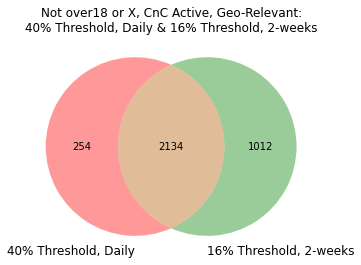

In [ ]:
plt.figure(figsize=(9, 4))

lbls_ = ['40% Threshold, Daily', '16% Threshold, 2-weeks']

mask_geo_default = df_all_subs['geo_relevant_subreddit'] == True
# .query doesn't return a mask, so don't use it here
mask_geo_new = df_all_subs['geo_relevant_subreddit_v04'] == True

s_geo_default = (
    df_all_subs[mask_active_subs & ~mask_over18_or_x & mask_geo_default]
    ['subreddit_name']
)
s_geo_new = (
    df_all_subs[mask_active_subs & ~mask_over18_or_x & mask_geo_new]
    ['subreddit_name']
)

get_venn_sets2(
    s_geo_default, s_geo_new,
    *lbls_
)
ax = venn2_unweighted(
    [
        set(s_geo_default), 
        set(s_geo_new),
    ],
    set_labels=lbls_,
)
plt.title(f"Not over18 or X, CnC Active, Geo-Relevant:\n{' & '.join(lbls_)}");

 7,499 <- 40% Threshold, Daily
10,994 <- 16% Threshold, 2-weeks
12,049 <- 40% Threshold, Daily + 16% Threshold, 2-weeks


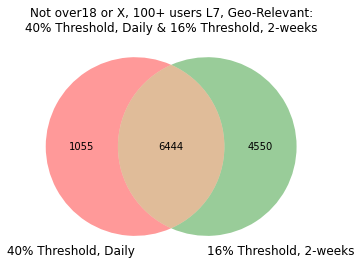

In [ ]:
plt.figure(figsize=(9, 4))

lbls_ = ['40% Threshold, Daily', '16% Threshold, 2-weeks']
mask_over_100_users_l7 = df_all_subs['users_l7'] >= 100

s_geo_default_100ul7 = (
    df_all_subs[mask_over_100_users_l7 & ~mask_over18_or_x & mask_geo_default]
    ['subreddit_name']
)
s_geo_new_100ul7 = (
    df_all_subs[mask_over_100_users_l7 & ~mask_over18_or_x & mask_geo_new]
    ['subreddit_name']
)

get_venn_sets2(
    s_geo_default_100ul7, s_geo_new_100ul7,
    *lbls_
)

ax = venn2_unweighted(
    [
        set(s_geo_default_100ul7), 
        set(s_geo_new_100ul7),
    ],
    set_labels=lbls_,
)
plt.title(f"Not over18 or X, 100+ users L7, Geo-Relevant:\n{' & '.join(lbls_)}");

## What are the counts per country with old definition v. new definition?

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_over_100_users_l7],  # [mask_geo_default],
    ['geo_relevant_countries'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
)

,subreddits_count,percent_of_subreddits
geo_relevant_countries,,
null,"127,131",91.5%
United Kingdom,"2,400",1.7%
Germany,"1,731",1.2%
India,"1,468",1.1%
Canada,"1,331",1.0%
Mexico,"1,187",0.9%
Brazil,798,0.6%
Australia,730,0.5%
France,384,0.3%


# Germany as a case study

Use one country to get details & test intuition. Then we can repeat the same functions/loop for each country.

- Tiers:
    - **Active subreddits**
        - Number of subs per geo (40% threshold v. 16% threshold)
            - %X of subs covered in model
            - Distribution of posts in L7 & L28
        - Number & % of SFW subs (NOT over_18 or rating=x)
            - %X of subs covered in model
            - Distribution of posts in L7 & L28

    - Subreddits with **over 100 users L7** (from geo-relevance score definition)
        - Number of subs per geo (40% threshold v. 16% threshold)
            - %Y of subs covered in model
            - Distribution of posts in L7 & L28
        - Number & % of SFW subs (NOT over_18 or rating=x)
            - %Y of subs covered in model
            - Distribution of posts in L7 & L28

    - Subreddits with **over 30 users L7 & 9 posts in L28**(threshold I used in v0.4.0)
        - Number of subs per geo (40% threshold v. 16% threshold)
            - %Z of subs covered in model
        - Number & % of SFW subs (NOT over_18 or rating=x)
            - %Z of subs covered in model

The point of the post counts at L7 & L28 is that we need to draw line for minimum requirement of posts. **Without enough posts, the text-based model isn't going to give good clusters.**


## Active subreddits

In [ ]:
mask_germany_default = df_all_subs['geo_relevant_countries'].fillna('').str.contains('Germany')
mask_germany_new = df_all_subs['geo_relevant_countries_v04'].fillna('').str.contains('Germany')

mask_subs_in_v04_model = df_all_subs['subreddit_in_v04_model'] == True

mask_subs_celebrity = df_all_subs['primary_topic'] == 'Celebrity'

print(mask_germany_default.sum())
print(mask_germany_new.sum())
print(mask_subs_in_v04_model.sum())

6662
5014
18772


In [ ]:
import plotly.graph_objects as go

n_active = mask_active_subs.sum()

mask_act_and_nsfw = (mask_active_subs & mask_over18_or_x)
n_act_labeled_nsfw = mask_act_and_nsfw.sum()
pct_act_labeled_nsfw = n_act_labeled_nsfw / mask_active_subs.sum()

mask_act_and_celeb = ((mask_active_subs & mask_subs_celebrity) & ~mask_over18_or_x)
n_act_celebrity_subs = mask_act_and_celeb.sum()
pct_act_celebrity = n_act_celebrity_subs / mask_active_subs.sum()

mask_act_sfw_or_unlab = mask_active_subs & ~(mask_act_and_nsfw | mask_act_and_celeb)
n_act_sfw_or_unlab = mask_act_sfw_or_unlab.sum()
pct_act_sfw_or_unlab = n_act_sfw_or_unlab / mask_active_subs.sum()

mask_act_geo_def = mask_active_subs & mask_geo_default
n_act_geo_def = mask_act_geo_def.sum()
pct_act_geo_def = n_act_geo_def / mask_active_subs.sum()

mask_act_geo_new = mask_active_subs & mask_geo_new
n_act_geo_new = mask_act_geo_new.sum()
pct_act_geo_new = n_act_geo_new / mask_active_subs.sum()

# Which subs are in the model?
mask_act_in_topic_model = mask_active_subs & mask_subs_in_v04_model
n_act_in_topic_model = mask_act_in_topic_model.sum()
pct_act_in_topic_model = n_act_in_topic_model / mask_active_subs.sum()

# Breakdown of geo in topic model
mask_act_topic_and_geo_new = mask_active_subs & mask_geo_new & mask_subs_in_v04_model
n_act_topic_and_geo_new = mask_act_topic_and_geo_new.sum()
pct_act_topic_and_geo_new = n_act_topic_and_geo_new / mask_active_subs.sum()
pct_act_geo_topic_and_geo_new = n_act_topic_and_geo_new / n_act_geo_new

# mask_act_topic_and_not_geo_new = ~mask_act_topic_and_geo_new
# n_act_topic_and_not_geo_new = mask_act_topic_and_not_geo_new.sum()
# pct_act_topic_and_not_geo_new = n_act_topic_and_not_geo_new / mask_active_subs.sum()
# pct_act_geo_topic_and_not_geo_new = n_act_topic_and_not_geo_new / n_act_geo_new


fig = go.Figure(go.Waterfall(
    name = "Overall Active Subreddits", orientation = "v",
    measure = [
        "relative", "relative", "relative", 
        "total",
        'relative',
        'relative',
        'relative',
        'relative',
    ],
    x = [
        "Labeled NSFW Subs", "Celebrity Subs",
        "SFW + Unlabeled Subs", 
        'Total Active Subs',
        'Geo @ 40%, Daily',
        'Geo @ 16%, 2-weeks',
        'Subs in Topic model',
        'Geo @ 16% in Topic model',
    ],
    text = [
        f"{n_act_labeled_nsfw:,.0f} |{pct_act_labeled_nsfw:.1%}", 
        f"{n_act_celebrity_subs:,.0f} |{pct_act_celebrity:.1%}",
        f"{n_act_sfw_or_unlab:,.0f} |{pct_act_sfw_or_unlab:.1%}",
        f"{n_active:,.0f}",
        f"{n_act_geo_def:,.0f} |{pct_act_geo_def:.1%}",
        f"{n_act_geo_new:,.0f} |{pct_act_geo_new:.1%}",
        f"{n_act_in_topic_model:,.0f} |{pct_act_in_topic_model:.1%}",
        f"{n_act_topic_and_geo_new:,.0f} {pct_act_geo_topic_and_geo_new:.1%} of Geo",
    ],
    y = [
        n_act_labeled_nsfw, n_act_celebrity_subs,  
        n_act_sfw_or_unlab,
        n_active,
        -n_act_geo_def,
        n_act_geo_new,
        -n_act_in_topic_model,
        n_act_topic_and_geo_new,
    ],
    # connector = {"line":{"color":"rgb(63, 63, 63)"}},
    textposition = "outside",
))

fig.update_layout(
        title = "Active Subreddits Overview",
        showlegend = True
)

fig.show()


## Try in swan

In [ ]:
# Breakdown of geo in topic model - exclude NSFW geo-relevant subs
mask_act_topic_and_geo_new = mask_active_subs & mask_geo_new & mask_subs_in_v04_model
n_act_topic_and_geo_new = mask_act_topic_and_geo_new.sum()
print()
pct_act_topic_and_geo_new = n_act_topic_and_geo_new / mask_active_subs.sum()
pct_act_geo_topic_and_geo_new = n_act_topic_and_geo_new / n_act_geo_new

In [ ]:


value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & ~mask_subs_celebrity & mask_geo_new],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Geo coverage - Active subs + SFW (Not over-18 or X-rated) + NOT celebrity")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,"2,015",65.8%
False,"1,046",34.2%


In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & mask_germany_default],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    add_col_prefix=False, cumsum=False,
    top_n=30,
).set_caption(f"Germany 40% Threshold - All active subs")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,241,54.4%
False,202,45.6%


In [ ]:
def display_mask_counts(
    country_name: str = 'Germany',
) -> None:
    """Create masks & display model coverage at different thresholds"""
    

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & mask_germany_default],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Germany 40% - Active subs + Not over-18 or X-rated")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,230,76.4%
False,71,23.6%


In [ ]:
value_counts_and_pcts(
    df_all_subs,
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Germany 40% - Active subs + Not over-18 or X-rated")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
False,"307,978",94.3%
True,"18,772",5.7%


In [ ]:


value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & ~mask_subs_celebrity & mask_germany_default],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Germany 40% - Active subs + SFW (Not over-18 or X-rated) + NOT celebrity")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,228,79.2%
False,60,20.8%


In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & mask_germany_new],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Germany 16% - Active subs + SFW (Not over-18 or X-rated)")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,272,85.8%
False,45,14.2%


In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & ~mask_subs_celebrity & mask_germany_new],
    ['subreddit_in_v04_model'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
).set_caption(f"Germany 16% - Active subs + SFW (Not over-18 or X-rated) + NOT celebrity")

,subreddits_count,percent_of_subreddits
subreddit_in_v04_model,,
True,270,89.4%
False,32,10.6%


In [ ]:

(
    df_all_subs[mask_active_subs & ~mask_over18_or_x & ~mask_subs_celebrity & mask_germany_new & ~mask_subs_in_v04_model]
    .query(
        f"over_18 != 't' & rating_short != 'X'"
    )
    # .shape
    # .head(10)
)

,subreddit_id,subreddit_name,subscribers,subreddit_age_months,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,over_100_users_l7,users_l7,users_l28,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,posts_l7,comments_l7,posts_l28,comments_l28,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam,subreddit_in_v04_model
3864,t5_2yy8ll,nicoledobrikov2,12771,15,1,False,True,Germany,DE,1.0,None,None,NaN,True,42165,79760,True,69.0,0_posters,NaN,0,60,8,92,no_ads,f,None,None,Sexual Orientation,NaN,None,restricted,False,None,False,False,False
7771,t5_50uf35,thecyclefrontier,2266,2,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,18215,20523,True,2939.0,2_or_more_posters,301.0,336,2281,423,2683,None,None,E,Everyone,Gaming,9.0,None,public,False,None,False,False,False
13721,t5_51m25m,bobaliberationarmy,574,2,0,True,True,Germany,DE,1.0,"Germany, United Kingdom","DE, GB",2.0,True,8575,11935,True,1094.0,2_or_more_posters,44.0,134,810,381,1635,None,None,E,Everyone,Funny/Humor,9.0,None,public,False,None,False,False,False
13843,t5_4rfx1f,popstantotnaked,3911,4,0,False,True,Germany,DE,1.0,None,None,NaN,True,8461,32066,True,59.0,0_posters,NaN,0,54,0,317,None,None,E,Everyone,Mature Themes and Adult Content,9.0,None,restricted,False,None,False,False,False
19320,t5_4qi9tm,snapnudestrade,442,4,0,False,True,Germany,DE,1.0,None,None,NaN,True,5197,12857,True,243.0,2_or_more_posters,63.0,75,122,179,334,None,None,None,None,None,NaN,None,public,False,None,False,False,False
19358,t5_4m0kl5,ginalaitschek_,4518,5,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,5180,13217,True,180.0,2_or_more_posters,24.0,68,76,166,232,None,None,E,Everyone,None,9.0,None,public,False,None,False,False,False
20407,t5_50hnrd,alexisshvof_,147,2,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,4780,9412,True,85.0,2_or_more_posters,13.0,15,59,37,101,None,None,None,None,None,NaN,None,public,False,None,False,False,False
25809,t5_4c18ws,drachenlord1510_offiz,355,7,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,3290,4776,True,87.0,2_or_more_posters,15.0,14,54,27,88,None,None,E,Everyone,Gaming,9.0,None,public,False,None,False,False,False
28482,t5_5159ky,german_nfsw_discord,164,2,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,2812,6652,True,184.0,2_or_more_posters,57.0,72,86,173,215,None,None,None,None,None,NaN,None,public,False,None,False,False,False
29541,t5_4p62cg,leoishorny,564,4,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,2646,6798,True,147.0,2_or_more_posters,19.0,23,95,93,575,None,f,None,None,None,NaN,None,public,False,None,False,False,False


### Model coverage appears low because I'm excluding NSFW subreddits & threshold definition

But that's on purpose -- I excluded over_18 & known `X` rated subs from the model (some of these ratings might've changed since I pulled data for modeling).

I excluded: 
- over_18
- rating=X
- primary_topic = `Celebrity`

However, some of them are excluded because they didn't show up as relevant with the new treshold & definition (16% over 2 weeks instead of 40% every day).

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_active_subs & mask_germany_default & ~mask_subs_in_v04_model],
    ['subreddit_in_v04_model', 'over_18', 'rating_short'], 
    count_type='subreddits', 
    # reset_index=True,
    sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
)

In [ ]:
# I also ignored "celebrity" subs because they tend to be porn/NSFW

value_counts_and_pcts(
    df_all_subs[mask_active_subs & mask_germany_default & ~mask_subs_in_v04_model],
    ['subreddit_in_v04_model', 'primary_topic'], 
    count_type='subreddits', 
    # reset_index=True,
    #sort_index=True,
    add_col_prefix=False,
    cumsum=False,
    top_n=30,
)

In [ ]:
(
    df_all_subs[mask_active_subs & mask_germany_default & ~mask_subs_in_v04_model]
    .query(
        f"over_18 != 't' & rating_short != 'X'"
    )
    .head(10)
)

,subreddit_id,subreddit_name,subscribers,subreddit_age_months,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,over_100_users_l7,users_l7,users_l28,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,posts_l7,comments_l7,posts_l28,comments_l28,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam,subreddit_in_v04_model
7226,t5_2ltn31,nonakanal,16183,19,1,True,True,Germany,DE,1.0,Germany,DE,1.0,True,19934,57624,True,669.0,2_or_more_posters,134.0,157,284,649,1348,None,None,E,Everyone,Celebrity,9.0,None,public,False,None,False,False,False
7771,t5_50uf35,thecyclefrontier,2266,2,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,18215,20523,True,2939.0,2_or_more_posters,301.0,336,2281,423,2683,None,None,E,Everyone,Gaming,9.0,None,public,False,None,False,False,False
11928,t5_492m30,celina_x31_of,8930,7,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,10410,27880,True,190.0,2_or_more_posters,30.0,27,117,127,388,None,f,E,Everyone,Celebrity,9.0,None,public,False,None,False,False,False
13376,t5_35t17,palinarojinski,11047,82,6,True,True,Germany,DE,1.0,Germany,DE,1.0,True,8905,25262,True,52.0,2_or_more_posters,10.0,11,21,45,70,None,None,E,Everyone,Celebrity,9.0,None,public,False,None,False,False,False
13721,t5_51m25m,bobaliberationarmy,574,2,0,True,True,Germany,DE,1.0,"Germany, United Kingdom","DE, GB",2.0,True,8575,11935,True,1094.0,2_or_more_posters,44.0,134,810,381,1635,None,None,E,Everyone,Funny/Humor,9.0,None,public,False,None,False,False,False
14132,t5_2hhaz3,anne_wuensche,7486,20,1,True,True,Germany,DE,1.0,Germany,DE,1.0,True,8188,17062,True,110.0,2_or_more_posters,11.0,15,72,36,179,None,None,E,Everyone,Celebrity,9.0,None,public,False,None,False,False,False
15466,t5_318as,oldcoins,2041,91,7,True,False,None,None,NaN,Germany,DE,1.0,True,7199,13707,True,125.0,2_or_more_posters,7.0,6,97,10,254,all_ads,None,E,Everyone,History,9.0,None,public,False,None,False,False,False
18655,t5_2p7prz,juliabeautxnew,3489,18,1,True,True,Germany,DE,1.0,Germany,DE,1.0,True,5458,14581,True,67.0,2_or_more_posters,16.0,16,34,60,172,None,None,None,None,Celebrity,NaN,None,public,False,None,False,False,False
19358,t5_4m0kl5,ginalaitschek_,4518,5,0,True,True,Germany,DE,1.0,Germany,DE,1.0,True,5180,13217,True,180.0,2_or_more_posters,24.0,68,76,166,232,None,None,E,Everyone,None,9.0,None,public,False,None,False,False,False
20386,t5_3jzzca,loredanazefi,3279,11,1,True,True,Germany,DE,1.0,Germany,DE,1.0,True,4787,12329,True,76.0,2_or_more_posters,19.0,21,34,72,87,None,f,E,Everyone,Celebrity,9.0,None,public,False,None,False,False,False


In [ ]:
(
    df_all_subs[mask_active_subs & mask_germany_default & ~mask_subs_in_v04_model]
    .query(
        f"over_18 != 't' & rating_short != 'X'"
    )
    .tail(10)
)

,subreddit_id,subreddit_name,subscribers,subreddit_age_months,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,over_100_users_l7,users_l7,users_l28,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,posts_l7,comments_l7,posts_l28,comments_l28,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam,subreddit_in_v04_model
243830,t5_y0uis,synonyco,7,32,2,True,False,None,None,NaN,Germany,DE,1.0,False,22,60,True,131.0,1_poster,1.0,131,0,401,0,None,None,None,None,None,NaN,None,restricted,False,None,False,False,False
248045,t5_4ogvdd,elhotzo,31,5,0,True,True,Germany,DE,1.0,Germany,DE,1.0,False,21,57,True,61.0,1_poster,1.0,61,0,224,0,None,None,None,None,None,NaN,None,restricted,False,None,False,False,False
273947,t5_23keku,yalikavak,24,27,2,True,False,None,None,NaN,Germany,DE,1.0,False,16,73,True,80.0,1_poster,1.0,80,0,282,0,None,None,None,None,None,NaN,None,public,False,None,False,False,False
287884,t5_4i8hfo,rgb_puppet,1,6,0,True,False,None,None,NaN,"Australia, Germany","AU, DE",2.0,False,14,52,True,53.0,2_or_more_posters,3.0,13,27,53,108,None,None,None,None,None,NaN,None,restricted,False,None,False,False,False
287915,t5_4exitg,10xengine,3,6,0,True,False,None,None,NaN,"Canada, Germany, India","CA, DE, IN",3.0,False,14,39,True,223.0,1_poster,1.0,75,74,304,271,None,None,None,None,None,NaN,None,restricted,False,None,False,False,False
287918,t5_45kgf0,netcve,23,8,0,True,False,None,None,NaN,"Germany, United Kingdom","DE, GB",2.0,False,14,103,True,418.0,1_poster,1.0,418,0,1431,0,None,None,None,None,None,NaN,None,public,False,None,False,False,False
296048,t5_44gwu7,elevenews,45,8,0,True,False,None,None,NaN,"Australia, Canada, Germany","AU, CA, DE",3.0,False,13,51,True,449.0,1_poster,1.0,449,0,1714,0,None,None,None,None,None,NaN,None,restricted,False,None,False,False,False
304924,t5_3pi7k,adrylas,18,49,4,True,False,None,None,NaN,"Brazil, Germany, Mexico, Switzerland","BR, CH, DE, MX",4.0,False,12,39,True,123.0,2_or_more_posters,3.0,123,0,438,0,None,f,None,None,None,NaN,None,restricted,False,t,False,False,False
315177,t5_3n0xc,catalanfeed,124,52,4,True,False,None,None,NaN,"Germany, Spain","DE, ES",2.0,False,11,45,True,169.0,1_poster,1.0,167,1,664,1,all_ads,None,E,Everyone,None,9.0,None,restricted,False,None,False,False,False
326749,t5_4zzu7r,getrichordietryin58,7,2,0,True,True,Germany,DE,1.0,Germany,DE,1.0,False,10,12,True,485.0,2_or_more_posters,2.0,485,0,625,0,None,None,None,None,None,NaN,None,private,False,None,False,False,False


# Swankey diagram / waterfall

Swankey diagram might be the better way to show break down of subreddits.

In [ ]:
df_all_subs.head()

,subreddit_id,subreddit_name,subscribers,subreddit_age_months,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,over_100_users_l7,users_l7,users_l28,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,posts_l7,comments_l7,posts_l28,comments_l28,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam,subreddit_in_v04_model
0,t5_4vo55w,profile,5,3,0,False,False,None,None,NaN,None,None,NaN,True,14127378,30058942,False,36.0,2_or_more_posters,4.0,28,4,46,6,None,None,None,None,None,NaN,None,public,False,None,False,False,False
1,t5_2qh1i,askreddit,33885477,166,13,False,False,None,None,NaN,None,None,NaN,True,11415794,29163940,True,1456284.0,2_or_more_posters,38150.0,67655,1304107,275759,5676664,all_ads,f,E,Everyone,Learning and Education,9.0,None,public,False,None,False,False,True
2,t5_2y77d,antiwork,883905,99,8,False,False,None,None,NaN,None,None,NaN,True,6719110,10496681,True,336387.0,2_or_more_posters,7541.0,8573,317006,17016,654452,all_ads,None,E,Everyone,Activism,9.0,None,public,False,None,False,False,True
3,t5_qir9n,holup,2644815,37,3,False,False,None,None,NaN,None,None,NaN,True,6157371,12168026,True,291866.0,2_or_more_posters,4944.0,6929,276991,25097,901715,some_ads,f,E,Everyone,None,9.0,None,public,False,t,False,False,True
4,t5_2qh0u,pics,28161395,166,13,False,False,None,None,NaN,None,None,NaN,True,5955877,12827493,True,180900.0,2_or_more_posters,4724.0,5823,169009,24594,672889,all_ads,f,E,Everyone,Art,9.0,admin-approved,public,False,None,False,False,True


### Dig into subreddits missed in new definition


In [ ]:
d_geo_subs = get_venn_sets2(
    s_geo_default,
    s_geo_new,
    '40%',
    '16%',
)
d_geo_subs.keys()

dict_keys(['40%_only', '40%_and_16%', '16%_only'])

In [ ]:
mask_geo_40_only = df_all_subs['subreddit_name'].isin(d_geo_subs['40%_only'])

mask_geo_40_only.sum()

254

In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_geo_40_only],
    ['rating_name'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
)

,subreddits_count,percent_of_subreddits
rating_name,,
null,136,53.5%
Everyone,116,45.7%
Mature,1,0.4%
Violence & Gore,1,0.4%


In [ ]:
value_counts_and_pcts(
    df_all_subs[mask_geo_40_only],
    ['primary_topic'], 
    count_type='subreddits', 
    # reset_index=True,
    # sort_index=True,
    add_col_prefix=False,
    cumsum=False,
)

,subreddits_count,percent_of_subreddits
primary_topic,,
null,163,64.2%
Gaming,14,5.5%
Crypto,11,4.3%
"Business, Economics, and Finance",8,3.1%
Funny/Humor,7,2.8%
Internet Culture and Memes,6,2.4%
Art,5,2.0%
World News,4,1.6%
Learning and Education,4,1.6%


In [ ]:
df_all_subs[mask_geo_40_only & mask_active_subs]

,subreddit_id,subreddit_name,subscribers,subreddit_age_months,subreddit_age_years,geo_relevant_subreddit,geo_relevant_subreddit_v04,geo_relevant_countries_v04,geo_relevant_country_codes_v04,geo_relevant_country_count_v04,geo_relevant_countries,geo_relevant_country_codes,geo_relevant_country_count,over_100_users_l7,users_l7,users_l28,active,activity_7_day,unique_posters_l7_bin,unique_posters_l7_submitted,posts_l7,comments_l7,posts_l28,comments_l28,ads_allow_list_status,over_18,rating_short,rating_name,primary_topic,rating_weight,verdict,type,quarantine,allow_discovery,is_deleted,is_spam,subreddit_in_v04_model
211,t5_4wyeb7,squidgame,115748,3,0,True,False,None,None,NaN,United Kingdom,GB,1.0,True,635900,2352163,True,32893.0,2_or_more_posters,2297.0,2344,26903,13952,136792,all_ads,None,V,Violence & Gore,Television,30.0,None,public,False,None,False,False,True
5252,t5_ezypb,wallstreetbetscrypto,30749,46,3,True,False,None,None,NaN,Canada,CA,1.0,True,29753,58252,True,5222.0,2_or_more_posters,215.0,288,4589,1309,20451,None,f,E,Everyone,"Business, Economics, and Finance",9.0,None,public,False,t,False,False,False
8103,t5_50amvj,shegothands,13907,2,0,True,False,None,None,NaN,"Australia, Canada","AU, CA",2.0,True,17300,63990,True,884.0,2_or_more_posters,11.0,29,755,166,3017,None,None,E,Everyone,Mature Themes and Adult Content,9.0,None,public,False,None,False,False,True
10757,t5_3jdw6,googlemapsshenanigans,110308,56,4,True,False,None,None,NaN,Australia,AU,1.0,True,11976,28263,True,232.0,2_or_more_posters,40.0,36,156,136,571,all_ads,None,E,Everyone,Funny/Humor,9.0,None,public,False,None,False,False,True
11608,t5_4ua51s,instinctgame,9822,3,0,True,False,None,None,NaN,United Kingdom,GB,1.0,True,10812,10907,True,153.0,2_or_more_posters,19.0,20,120,28,153,None,None,None,None,None,NaN,None,public,False,None,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315175,t5_2thrgz,el3rod_kuwait,15,16,1,True,False,None,None,NaN,India,IN,1.0,False,11,61,True,128.0,1_poster,1.0,128,0,453,0,None,None,None,None,None,NaN,None,public,False,None,False,False,False
315177,t5_3n0xc,catalanfeed,124,52,4,True,False,None,None,NaN,"Germany, Spain","DE, ES",2.0,False,11,45,True,169.0,1_poster,1.0,167,1,664,1,all_ads,None,E,Everyone,None,9.0,None,restricted,False,None,False,False,False
326086,t5_2i8pf9,fanmademaskedsinger,16,20,1,True,False,None,None,NaN,Australia,AU,1.0,False,10,15,True,206.0,1_poster,1.0,1,203,2,205,None,None,None,None,None,NaN,None,public,False,None,False,False,False
326747,t5_3n2r4,bcsfeed,38,52,4,True,False,None,None,NaN,United Kingdom,GB,1.0,False,10,37,True,121.0,1_poster,1.0,121,0,482,0,all_ads,None,E,Everyone,None,9.0,None,restricted,False,None,False,False,False
